# load & filter data

In [1]:
ts <- read.csv("data/timeseries.csv")
head(ts)

,sim_number,time,chemostat_id,integer,frequency
,<int>,<dbl>,<int>,<int>,<int>
1,1,0,1,1,1000
2,1,1,1,1,1000
3,1,1,1,4,91
4,1,1,1,10,7
5,1,1,1,5,46
6,1,1,1,8,13


In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(purrr)

# Simulated input
nsim <- max(ts$sim_number)

# Extract `outflow_rate`
params <- read.csv("data/params.csv")
k_ds <- params$outflow_rate

Warning message:
“package ‘dplyr’ was built under R version 4.3.1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyr’ was built under R version 4.3.1”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.1”


In [3]:
# Calculate total populations
f <- filter(ts, time == 100)

total_populations <- map_int(1:nsim, function(i) {
  ff <- filter(f, sim_number == i)
  gff <- ff %>%
    group_by(integer) %>%
    summarise(frequency = sum(frequency), .groups = "drop")
  sum(gff$frequency)
})

In [4]:
# Calculate max detectable integers
thresholds <- c(1e-5, 1e-4, 1e-3, 1e-2, 1e-1)
nthresh <- length(thresholds)
highest_integer <- matrix(0, nrow = nsim, ncol = nthresh)

for (i in 1:nsim) {
  ff <- filter(f, sim_number == i)
  gff <- ff %>%
    group_by(integer) %>%
    summarise(frequency = sum(frequency), .groups = "drop") %>%
    mutate(fraction = frequency / total_populations[i])
  for (j in 1:nthresh) {
    filtered_gff <- filter(gff, fraction > thresholds[j])
    if (nrow(filtered_gff) > 0) {
      sorted_gff <- arrange(filtered_gff, desc(integer))
      highest_integer[i, j] <- sorted_gff$integer[1]
    }
  }
}

In [5]:
library(tidyr)
library(dplyr)

# Convert the matrix to a dataframe and add simulation and threshold columns
highest_integer_df <- as.data.frame(highest_integer) %>%
  mutate(sim_number = row_number()) %>%
  pivot_longer(cols = starts_with("V"), names_to = "threshold", values_to = "integer") %>%
  mutate(threshold = as.numeric(gsub("V", "", threshold))) # Assuming thresholds are sequentially named V1, V2, ...

# Add the actual threshold values if they are not sequential
thresholds <- c(1e-5, 1e-4, 1e-3, 1e-2, 1e-1) # Update this vector as needed
highest_integer_df$threshold <- thresholds[highest_integer_df$threshold]

# print(highest_integer_df)

In [6]:
# Convert integers to AIs
ai <- read.csv("Assembly-10000.csv")

# Define the function
calculate_assembly_index <- function(integer) {
  
  result <- ai$assemblyindex[ai$integer == integer]
  
  # Return NA if no match is found
  if (length(result) == 0) {
    return(NA) 
  }
  
  return(result)
}

# highest_AI <- matrix(0, nrow = nsim, ncol = nthresh)
# for (i in 1:nsim) {
#   for (j in 1:nthresh) {
#     highest_AI[i, j] <- calculate_assembly_index(highest_integer[i, j])
#   }
# }

In [7]:
library(dplyr)

highest_integer_df <- highest_integer_df %>%
  mutate(assemblyindex = sapply(integer, calculate_assembly_index))

# print(highest_integer_df)

In [8]:
highest_integer_df <- highest_integer_df %>%
  left_join(params %>% select(sim_number, outflow_rate), by = "sim_number")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 20 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


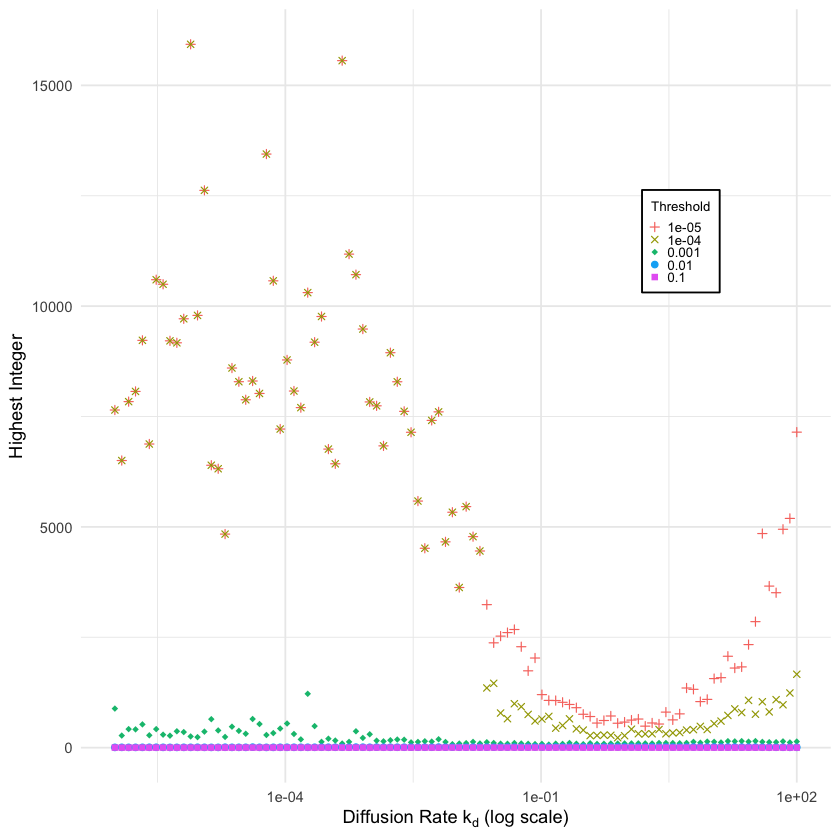

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 20 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


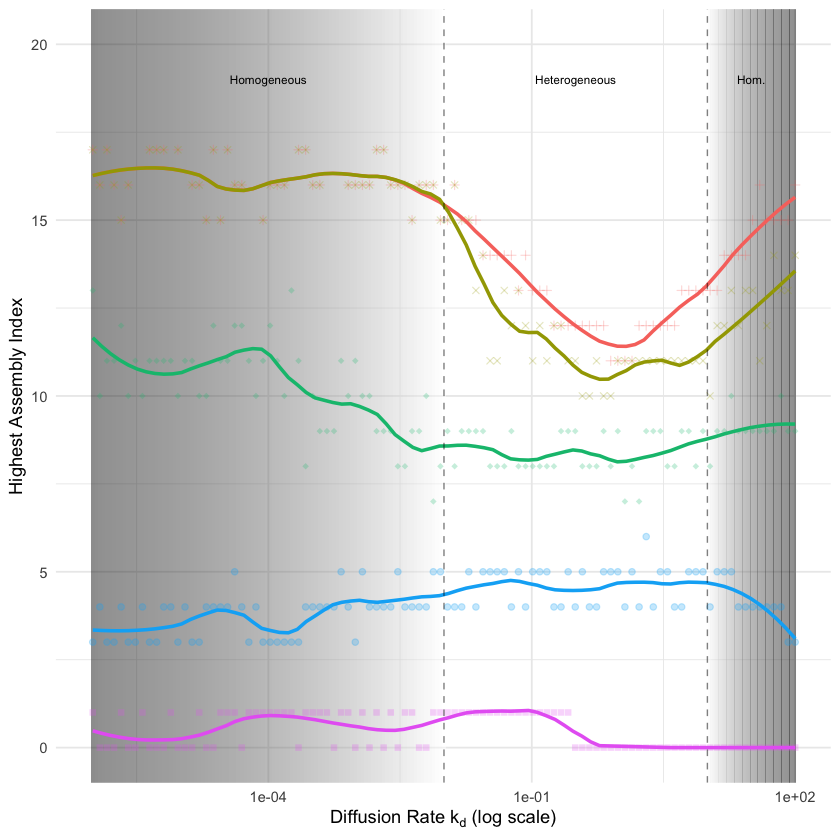

In [12]:
library(latex2exp)

ggplot(highest_integer_df, aes(x = outflow_rate, y = integer, shape = factor(threshold), color = factor(threshold))) +
  geom_point(alpha = 1.00) +
  scale_shape_manual(values = c(3, 4, 18, 19, 15)) +
  scale_x_log10() +
  labs(
    x = TeX("Diffusion Rate $k_d$ (log scale)"),
    y = "Highest Integer",
    shape = "Threshold",
    color = "Threshold"
  ) +
  theme_minimal() +
  theme(
    legend.position = c(0.8, 0.7),  # Adjust position as needed
    legend.background = element_rect(fill = "white", color = "black"),  # White background and black border
    legend.box.background = element_rect(color = "black"),  # Box around the legend
    legend.key.size = unit(0.15, "cm"),    # Decrease key size
    legend.text = element_text(size = 8), # Decrease text size
    legend.title = element_text(size = 8) # Decrease title size
  )
ggsave("figs/09C_detection_thresholds_int.pdf", width = 80, height = 70, units = "mm")



#   ggplot(highest_integer_df, aes(x = outflow_rate, y = assemblyindex, shape = factor(threshold), color = factor(threshold))) +
#   geom_point(alpha = 0.25) +
#   scale_shape_manual(values = c(3, 4, 18, 19, 15)) +
#   geom_smooth(method = "loess", span = 0.25, se = FALSE) + # Add smooth curves for each series
#   # Add vertical dashed line at x=1e-2
#   geom_vline(xintercept = 1e-2, alpha = 0.5, linetype = "dashed") +
#   # Add horizontal gradient background to the left of x=1e-2
#   # annotate("rect", xmin = 1e-6, xmax = 1e-2, ymin = -Inf, ymax = Inf,
#   #          fill = "grey80", alpha = 0.5) +
#   # annotate("rect", xmin = 1e-6, xmax = 1e-2, ymin = -Inf, ymax = Inf,
#   #          fill = "grey90", alpha = 0.25) +
#   # Add a horizontal arrow pointing right from the dashed line
#   annotate("segment", x = 1e-2, xend = 1e-2 + 0.25, y = 17, yend = 17,
#            arrow = arrow(length = unit(0.2, "cm"))) +
#   # Add annotation near the arrow
#   annotate("text", x = 1e-2 + 0.01, y = 16, label = "Heterogeneous regime",
#            hjust = 0, size = 2.5) +
#   scale_x_log10() +
#   labs(
#     x = TeX("Diffusion Rate $k_d$ (log scale)"),
#     y = "Highest AI",
#     shape = "Threshold",
#     color = "Threshold"
#   ) +
#   theme_minimal() +
#   theme(
#     # legend.position = c(0.2, 0.3),  # Adjust position as needed
#     legend.position = "none",  # Adjust position as needed
#     legend.background = element_rect(fill = "white", color = "black"),  # White background and black border
#     legend.box.background = element_rect(color = "black"),  # Box around the legend
#     legend.key.size = unit(0.15, "cm"),    # Decrease key size
#     legend.text = element_text(size = 8), # Decrease text size
#     legend.title = element_text(size = 8) # Decrease title size
#   )
# ggsave("figs/09C_detection_thresholds_AI.pdf", width = 80, height = 70, units = "mm")

library(ggplot2)
library(scales)

library(ggplot2)
library(dplyr)
library(ggnewscale)

# Build ribbon data
ribbon1_data <- data.frame(
  x = 10^seq(-6, -2, length.out = 100),
  ymin = -Inf,
  ymax = Inf,
  fill_value = log10(10^seq(-6, -2, length.out = 100))
)

ribbon2_data <- data.frame(
  x = 10^seq(1, 2, length.out = 100),
  ymin = -Inf,
  ymax = Inf,
  fill_value = log10(10^seq(1, 2, length.out = 100))
)

p <- ggplot(highest_integer_df, 
            aes(x = outflow_rate, 
                y = assemblyindex, 
                shape = factor(threshold), 
                color = factor(threshold))) +
  # FIRST RIBBON (black->white)
  geom_tile(data = ribbon1_data,
            aes(x = x, y = 0, fill = fill_value),
            height = Inf,   # fill entire height
            alpha = 0.45,
            inherit.aes = FALSE) +
  scale_fill_gradient(low = "black", high = "white", name = "Gradient1") +
  
  # Begin a new fill scale so we can apply a different gradient
  new_scale_fill() +
  
  # SECOND RIBBON (white->black)
  geom_tile(data = ribbon2_data,
            aes(x = x, y = 0, fill = fill_value),
            height = Inf,
            alpha = 0.45,
            inherit.aes = FALSE) +
  scale_fill_gradient(low = "white", high = "black", name = "Gradient2") +
  
  # Additional layers on your main data
  geom_point(alpha = 0.25) +
  scale_shape_manual(values = c(3, 4, 18, 19, 15)) +
  geom_smooth(method = "loess", span = 0.25, se = FALSE) +
  
  # Vertical reference lines
  geom_vline(xintercept = 1e-2, linewidth = 0.4, alpha = 0.5, linetype = "dashed") +
  geom_vline(xintercept = 1e1, linewidth = 0.4, alpha = 0.5, linetype = "dashed") +
  
  # A few annotations
  # annotate("segment", x = 1e-2, xend = 1e-2 + 0.25, y = 17, yend = 17,
  #          arrow = arrow(length = unit(0.2, "cm"))) +
  annotate("text", x = 1e-4, y = 19, label = "Homogeneous",
           hjust = 0.5, size = 2.5) +
  annotate("text", x = 3.16e-1, y = 19, label = "Heterogeneous",
           hjust = 0.5, size = 2.5) +
  annotate("text", x = 3.16e1, y = 19, label = "Hom.",
           hjust = 0.5, size = 2.5) +                      
  
  # Log-scale x
  scale_x_log10() +
  ylim(0, 20) +
  
  labs(
    x = TeX("Diffusion Rate $k_d$ (log scale)"),
    y = "Highest Assembly Index",
    shape = "Threshold",
    color = "Threshold"
  ) +
  theme_minimal() +
  # Hide or position legends as you wish
  theme(
    legend.position = "none",
    legend.background = element_rect(fill = "white", color = "black"),
    legend.box.background = element_rect(color = "black"),
    legend.key.size = unit(0.15, "cm"),
    legend.text = element_text(size = 8),
    legend.title = element_text(size = 8)
  )

p

ggsave("figs/09C_detection_thresholds_AI.pdf", plot = p, width = 80, height = 70, units = "mm")

In [103]:
install.packages("ggnewscale")


The downloaded binary packages are in
	/var/folders/t8/fkkfhnjd1xq691rgcx70_zkm0000gn/T//RtmpL3T5pn/downloaded_packages
